<a href="https://colab.research.google.com/github/anelglvz/Matematicas_Ciencia_Datos/blob/main/Optimizaci%C3%B3n/Calculo_Opt_Problema_del_Viajante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Utilizaremos programación lineal para resolver el **Problema del Viajante** (Travel Salesman Problem).

El problema es encontrar la **ruta más corta que conecta a todas las ciudades**, con las restricciones de que debe ser una única ruta (i.e. no puede haber sub rutas) y sólo se puede entrar y salir de cada ciudad una sola vez.

Se crearán las "coordenadas" de ciudades ficticias y para medir su distancia se usará la distancia euclideana.

# Dependencias

La documentación de MIP se encuentra en: https://python-mip.readthedocs.io/en/latest/quickstart.html

In [ ]:
!pip3 install mip==1.16rc0 # Python-MIP’s latest release candidate version (1.16rc0) includes binaries compatible with M1/M2/M3 processors.

In [ ]:
!pip3 install -U plotly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.spatial import distance_matrix

from itertools import product
from mip import Model, xsum, minimize, BINARY

import plotly.express as px
import plotly.io as pio

In [2]:
np.set_printoptions(legacy='1.25')

In [3]:
pio.templates.default = "plotly_white"

# Funciones para la visualización de los datos

In [4]:
def plot_cities(coords):
    fig = px.scatter(coords.reset_index(), 'x', 'y', hover_name='index')
    fig.update_traces(marker=dict(size=15,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers')
                    )
    return fig

def plot_cities_and_route(points, edges):
    fig = plot_cities(points)
    for edge in edges:
        fig.add_shape(
            type = 'line',
            x0 = points.loc[f'ciudad_{edge[0]}', 'x'],
            x1 = points.loc[f'ciudad_{edge[1]}', 'x'],
            y0 = points.loc[f'ciudad_{edge[0]}', 'y'],
            y1 = points.loc[f'ciudad_{edge[1]}', 'y'],
            line = dict(color = 'rgb(0, 0, 0)'),
            opacity = .09,
            )
        fig.add_scatter(x = [mid_points[edge[0]][edge[1]][0]], y = [mid_points[edge[0]][edge[1]][1]], text = [d[edge[0]][edge[1]]], mode='text')
    fig.update_traces(texttemplate='%{text:.2s}', textposition='top right')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', showlegend=False)
    fig.show()

In [5]:
def get_middle_points(coords):
    return [[((x[0]+y[0])/2, (x[1]+y[1])/2) for _, y in coords.iterrows()] for _, x in coords.iterrows()]

# Datos

Primero crearemos las ciudades y sus coordenadas

In [6]:
np.random.seed(10)

n = 10 # número de ciudades

points = pd.DataFrame(np.random.randint(0, 30, (n, 2)), columns = ['x', 'y'], index = [f'ciudad_{i}' for i in range(n)])  # coordenadas en el plano cartesiano de cada ciudad
points

,x,y
ciudad_0,9,29
ciudad_1,4,15
ciudad_2,0,17
ciudad_3,27,28
ciudad_4,25,29
ciudad_5,16,29
ciudad_6,17,26
ciudad_7,8,9
ciudad_8,0,10
ciudad_9,8,22


Obtenemos el punto medio entre cada ciudad

In [7]:
mid_points = get_middle_points(points)

/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_9476/2772611435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [[((x[0]+y[0])/2, (x[1]+y[1])/2) for _, y in coords.iterrows()] for _, x in coords.iterrows()]


In [9]:
mid_points

[[(9.0, 29.0),
  (6.5, 22.0),
  (4.5, 23.0),
  (18.0, 28.5),
  (17.0, 29.0),
  (12.5, 29.0),
  (13.0, 27.5),
  (8.5, 19.0),
  (4.5, 19.5),
  (8.5, 25.5)],
 [(6.5, 22.0),
  (4.0, 15.0),
  (2.0, 16.0),
  (15.5, 21.5),
  (14.5, 22.0),
  (10.0, 22.0),
  (10.5, 20.5),
  (6.0, 12.0),
  (2.0, 12.5),
  (6.0, 18.5)],
 [(4.5, 23.0),
  (2.0, 16.0),
  (0.0, 17.0),
  (13.5, 22.5),
  (12.5, 23.0),
  (8.0, 23.0),
  (8.5, 21.5),
  (4.0, 13.0),
  (0.0, 13.5),
  (4.0, 19.5)],
 [(18.0, 28.5),
  (15.5, 21.5),
  (13.5, 22.5),
  (27.0, 28.0),
  (26.0, 28.5),
  (21.5, 28.5),
  (22.0, 27.0),
  (17.5, 18.5),
  (13.5, 19.0),
  (17.5, 25.0)],
 [(17.0, 29.0),
  (14.5, 22.0),
  (12.5, 23.0),
  (26.0, 28.5),
  (25.0, 29.0),
  (20.5, 29.0),
  (21.0, 27.5),
  (16.5, 19.0),
  (12.5, 19.5),
  (16.5, 25.5)],
 [(12.5, 29.0),
  (10.0, 22.0),
  (8.0, 23.0),
  (21.5, 28.5),
  (20.5, 29.0),
  (16.0, 29.0),
  (16.5, 27.5),
  (12.0, 19.0),
  (8.0, 19.5),
  (12.0, 25.5)],
 [(13.0, 27.5),
  (10.5, 20.5),
  (8.5, 21.5),
  (22.0, 

Creamos la matriz de distancias

In [10]:
d = distance_matrix(points, points)  # Distancia entre las ciudades
d

array([[ 0.        , 14.86606875, 15.        , 18.02775638, 16.        ,
         7.        ,  8.54400375, 20.02498439, 21.02379604,  7.07106781],
       [14.86606875,  0.        ,  4.47213595, 26.41968963, 25.23885893,
        18.43908891, 17.02938637,  7.21110255,  6.40312424,  8.06225775],
       [15.        ,  4.47213595,  0.        , 29.15475947, 27.73084925,
        20.        , 19.23538406, 11.3137085 ,  7.        ,  9.43398113],
       [18.02775638, 26.41968963, 29.15475947,  0.        ,  2.23606798,
        11.04536102, 10.19803903, 26.87005769, 32.44996148, 19.92485885],
       [16.        , 25.23885893, 27.73084925,  2.23606798,  0.        ,
         9.        ,  8.54400375, 26.2488095 , 31.40063694, 18.38477631],
       [ 7.        , 18.43908891, 20.        , 11.04536102,  9.        ,
         0.        ,  3.16227766, 21.54065923, 24.8394847 , 10.63014581],
       [ 8.54400375, 17.02938637, 19.23538406, 10.19803903,  8.54400375,
         3.16227766,  0.        , 19.23538406

## Visualización de los datos

In [11]:
plot_cities_and_route(points, product(range(n), range(n))) # Visualización de las ciudades

6 -> 5 -> 2 -> 1 -> ....

## TSP (Travelling salesman problem) con programación lineal

Considere $n$ puntos, $V = \left\{0, 1, \dots, n-1 \right\}$, y la matriz de distancia $D_{n\times n}$ con entradas $d_{i, j} \in \mathbb{R^+}$.

La variable $x_{i,j}$ es tal que
$$  x_{i,j} = \begin{cases} 1 & \text{ el camino va de la ciudad } i \text{ a la ciudad } j\text{,} \\ 0 & \text{caso contrario.} \end{cases} $$

Tomando una variable dummy $y_i$ que guarda información del orden en que se visitan las ciudades, a partir de la ciudad $0$. Esto se escribe como $ y_i < y_j$ si la ciudad $i$ se visita antes que la ciudad $j$.

Programación lineal favorece la desigualdades no-estrictas respecto a la estrictas, por lo que se puede imponer una condición parecida a la siguiente

$$ y_j \geqslant y_i + x_{i,j} $$

cuando $x_{i,j} = 1$ (NOTESE que no es lo mismo que tomar solo $ y_j \geqslant y_i + x_{i,j}$ en el caso general de $x_{i,j}$)


La solución es un conjunto de $n$ pares de puntos indicando la ciudad de salida y ciudad de llegada. Considerando las restricciones que se mencionaron al inicio, tenemos que

Minimizar:
$$\sum_{i\in V, j\in V} d_{i, j}x_{i, j}$$
Sujeto a:
\begin{align}
\sum_{i\in V\setminus \{j\}} x_{i, j} = 1 && \forall j \in V \\
\sum_{j\in V\setminus \{i\}} x_{i, j} = 1 && \forall i \in V \\
y_j - (n-1)x_{i, j} \geq y_i - (n-2) && \forall i \in V \setminus \{0\}, j\in V\setminus \{0, i\} \\
x_{i, j} \in \{0, 1\} && \forall i\in V, j \in V \\
y_i \geq 0 && \forall i \in V
\end{align}

In [12]:
# Número de nodos y vértices
n, V = len(points), set(range(len(points)))
print(f'Número de nodos:\tn = {n}\nVértices:\tV = {V}')

Número de nodos:	n = 10
Vértices:	V = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


En MacOS, puede que se necesiten las siguientes dos líneas para que MIP funcione:

In [ ]:
!brew tap coin-or-tools/coinor
!brew install cbc

In [13]:
model = Model()

# Variables binarias que indican si se toma el camino de la ciudad i a la j
x = [[model.add_var(var_type=BINARY) for j in V] for i in V]

# Variables continuas para evitar subrutas
y = [model.add_var() for i in V]

$$\sum_{i\in V, j\in V} d_{i, j}x_{i, j}$$


In [14]:
# Función objetivo:
model.objective = minimize(xsum(d[i][j]*x[i][j] for i in V for j in V))

$$\sum_{j\in V\setminus \{i\}} x_{i, j} = 1 \text{, } \forall i \in V$$

In [15]:
# Restricción : Sal de cada ciudad una única vez
for i in V:
    model += xsum(x[i][j] for j in V - {i}) == 1

$$\sum_{i\in V\setminus \{j\}} x_{i, j} = 1 \text{, } \forall j \in V$$

In [16]:
# Restricción : Entra a cada ciudad una única vez
for j in V:
    model += xsum(x[i][j] for i in V - {j}) == 1

$$y_j - (n-1)x_{i, j} \geq y_i - (n-2) \text{, } \forall i \in V \setminus \{0\}, j\in V\setminus \{0, i\}$$

In [17]:
# Elimina subrutas
for (i, j) in product(V - {0}, V - {0}):
    if i != j:
        model += y[j] - (n-1)*x[i][j] >= y[i]-(n-2)

In [18]:
# Optimizar
model.optimize()

# Revisar si se encontró una solución
edges = []
if model.num_solutions:
    print('Ruta con distancia total %g encontrada: %s'
              % (model.objective_value, points.index[0]))
    nc = 0 # Indice de la ciudad actual
    while True:
        oc = nc
        nc = [i for i in V if x[nc][i].x >= 0.99][0] # Indice de la ciudad a la que se siguió
        edges.append((oc, nc)) # Guardamos el camino a tomar
        print(' -> %s' % points.index[nc]) # Imprimimos el siguiente paso de la ruta
        if nc == 0:  # Si regresa al inicio terminamos el ciclo
            break
    print('\n')

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Jan 16 2024
Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 92 (0) rows, 99 (-11) columns and 396 (0) elements
Clp1000I sum of infeasibilities 0.000183017 - average 1.98932e-06, 51 fixed columns
Coin0506I Presolve 92 (0) rows, 48 (-51) columns and 255 (-141) elements
Clp0029I End of values pass after 48 iterations
Clp0000I Optimal - objective value 53.446815
Clp0000I Optimal - objective value 53.446815
Coin0511I After Postsolve, objective 53.446815, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 53.446815
Clp0000I Optimal - objective value 53.446815
Clp0000I Optimal - objective value 53.446815
Coin0511I After Postsolve, objective 53.446815, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 53.4468148 - 0 iterations time 0.012, Presolve 0.00, Idiot 0.01

Starting MIP optimization
maxSavedSolutions was changed from 1 to 10
C

In [19]:
edges

[(0, 9),
 (9, 1),
 (1, 2),
 (2, 8),
 (8, 7),
 (7, 6),
 (6, 3),
 (3, 4),
 (4, 5),
 (5, 0)]

In [20]:
plot_cities_and_route(points, edges)

## Datos Reales

Datos provenientes de: https://pmc.ncbi.nlm.nih.gov/articles/PMC5780421/

In [ ]:
!pip3 install geopandas==1.0
!pip3 install openpyxl

In [22]:
import geopandas as gpd
from shapely.geometry import Point

In [23]:
#import data from file
ruta = '41598_2018_19772_MOESM3_ESM.xlsx'
data = pd.read_excel(ruta)
print(data.shape)
data.head()

(593, 9)


,Number of positive case,Total number of sample,Latitude,Longitude,Time index,Intercept,Temperature,Precipitation,Relative humidity
0,0,136,46.12,14.82,22,1,9.8,133.0,0.833607
1,0,143,46.12,14.82,23,1,2.9,1.0,0.917059
2,3,185,46.12,14.82,24,1,1.9,56.7,0.856400
3,27,170,46.12,14.82,25,1,0.8,26.5,0.679756
4,135,283,46.12,14.82,26,1,-2.5,35.4,0.767403


/Users/pedrom2/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



(-25.0, 150.0)

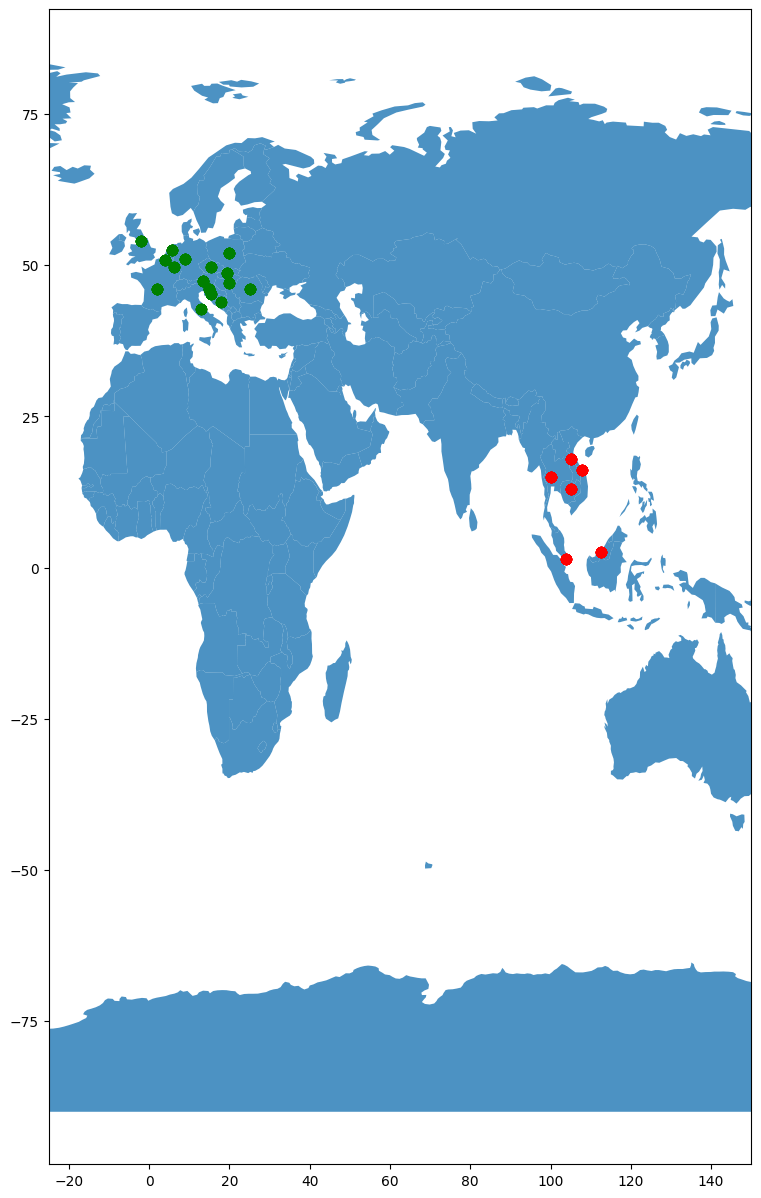

In [39]:
geometry = [Point(xy) for xy in zip(data['Longitude'],data['Latitude'])]
crs = {'init' : 'epsg:4326'}
geo_df = gpd.GeoDataFrame(data, crs = crs, geometry = geometry)

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

fig , ax = plt.subplots(figsize=(15,15))
world.plot(ax=ax, alpha=0.8)
geo_df[geo_df['Longitude'] > 90 ].plot(ax=ax, marker='o', color='red', markersize=50);
geo_df[geo_df['Longitude'] <= 90 ].plot(ax=ax, marker='o', color='green', markersize=50);
plt.xlim(-25,150)

In [25]:
def Haversine(A,B):
    """
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is,
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    lat1,lon1,lat2,lon2 = A[0],A[1],B[0],B[1]

    R = 6378.0088
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d = R * c
    return round(d,4)

In [26]:
location = data[['Latitude','Longitude']].drop_duplicates(subset=['Latitude','Longitude'])
location = location[location['Longitude'] <= 90].copy()
location.columns = ['x', 'y']
n = location.shape[0] #number of locations
print(n)
location.index = [f'ciudad_{i}' for i in range(n)]
print(location)

16
               x      y
ciudad_0   46.12  14.82
ciudad_1   48.67  19.50
ciudad_2   52.00  20.00
ciudad_3   47.33  13.33
ciudad_4   50.83   4.00
ciudad_5   44.00  18.00
ciudad_6   51.00   9.00
ciudad_7   46.00   2.00
ciudad_8   52.50   5.75
ciudad_9   49.75  15.50
ciudad_10  45.17  15.50
ciudad_11  49.75   6.17
ciudad_12  46.00  25.00
ciudad_13  47.00  20.00
ciudad_14  42.83  12.83
ciudad_15  54.00  -2.00


In [27]:
mid_points = get_middle_points(location)
mid_points

/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_9476/2772611435.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



[[(46.12, 14.82),
  (47.394999999999996, 17.16),
  (49.06, 17.41),
  (46.724999999999994, 14.075),
  (48.474999999999994, 9.41),
  (45.06, 16.41),
  (48.56, 11.91),
  (46.06, 8.41),
  (49.31, 10.285),
  (47.935, 15.16),
  (45.644999999999996, 15.16),
  (47.935, 10.495000000000001),
  (46.06, 19.91),
  (46.56, 17.41),
  (44.474999999999994, 13.825),
  (50.06, 6.41)],
 [(47.394999999999996, 17.16),
  (48.67, 19.5),
  (50.335, 19.75),
  (48.0, 16.415),
  (49.75, 11.75),
  (46.335, 18.75),
  (49.835, 14.25),
  (47.335, 10.75),
  (50.585, 12.625),
  (49.21, 17.5),
  (46.92, 17.5),
  (49.21, 12.835),
  (47.335, 22.25),
  (47.835, 19.75),
  (45.75, 16.165),
  (51.335, 8.75)],
 [(49.06, 17.41),
  (50.335, 19.75),
  (52.0, 20.0),
  (49.665, 16.665),
  (51.415, 12.0),
  (48.0, 19.0),
  (51.5, 14.5),
  (49.0, 11.0),
  (52.25, 12.875),
  (50.875, 17.75),
  (48.585, 17.75),
  (50.875, 13.085),
  (49.0, 22.5),
  (49.5, 20.0),
  (47.415, 16.415),
  (53.0, 9.0)],
 [(46.724999999999994, 14.075),
  (48.

In [28]:
d = np.zeros((n,n))  # Distancia entre las ciudades
for i in range(n):
  for j in range(n):
    d[i,j] = Haversine(location.iloc[i], location.iloc[j])

d[:5, :5]

/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_9476/4227549280.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



array([[   0.    ,  452.5656,  755.324 ,  176.2595,  953.7728],
       [ 452.5656,    0.    ,  372.3824,  483.015 , 1138.1928],
       [ 755.324 ,  372.3824,    0.    ,  707.3821, 1116.1166],
       [ 176.2595,  483.015 ,  707.3821,    0.    ,  783.1196],
       [ 953.7728, 1138.1928, 1116.1166,  783.1196,    0.    ]])

## Visualización de los datos

In [29]:
plot_cities_and_route(location, product(range(n), range(n))) # Visualización de las ciudades

## TSP (Travelling salesman problem) con programación lineal

In [30]:
# Número de nodos y vértices
n, V = len(location), set(range(len(location)))
print(f'Número de nodos:\tn = {n}\nVértices:\tV = {V}')

Número de nodos:	n = 16
Vértices:	V = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


In [31]:
model = Model()

# Variables binarias que indican si se toma el camino de la ciudad i a la j
x = [[model.add_var(var_type=BINARY) for j in V] for i in V]

# Variables continuas para evitar subrutas
y = [model.add_var() for i in V]

In [32]:
# Función objetivo:
model.objective = minimize(xsum(d[i][j]*x[i][j] for i in V for j in V))

In [33]:
# Restricción : Sal de cada ciudad una única vez
for i in V:
    model += xsum(x[i][j] for j in V - {i}) == 1

In [34]:
# Restricción : Entra a cada ciudad una única vez
for j in V:
    model += xsum(x[i][j] for i in V - {j}) == 1

In [35]:
# Elimina subrutas
for (i, j) in product(V - {0}, V - {0}):
    if i != j:
        model += y[j] - (n-1)*x[i][j] >= y[i]-(n-2)

In [36]:
# Optimizar
model.optimize()

# Revisar si se encontró una solución
edges = []
if model.num_solutions:
    print('Ruta con distancia total %g encontrada: %s'
              % (model.objective_value, location.index[0]))
    nc = 0 # Indice de la ciudad actual
    while True:
        oc = nc
        nc = [i for i in V if x[nc][i].x >= 0.99][0] # Indice de la ciudad a la que se siguió
        edges.append((oc, nc)) # Guardamos el camino a tomar
        print(' -> %s' % location.index[nc]) # Imprimimos el siguiente paso de la ruta
        if nc == 0:  # Si regresa al inicio terminamos el ciclo
            break
    print('\n')

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 242 (0) rows, 255 (-17) columns and 1110 (0) elements
Clp1000I sum of infeasibilities 1.38146e-05 - average 5.7085e-08, 207 fixed columns
Coin0506I Presolve 211 (-31) rows, 22 (-233) columns and 454 (-656) elements
Clp0006I 0  Obj 5932.5256 Primal inf 2.5532902e-06 (1) Dual inf 2.032531e+12 (6)
Clp0029I End of values pass after 22 iterations
Clp0000I Optimal - objective value 5932.5261
Clp0000I Optimal - objective value 5932.5261
Coin0511I After Postsolve, objective 5932.5261, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 5932.5261 Dual inf 2400.5465 (10)
Clp0014I Perturbing problem by 0.001% of 0.96888911 - largest nonzero change 1.435255e-05 ( 0.0007423733%) - largest zero change 1.9472032e-05
Clp0000I Optimal - objective value 5932.5261
Clp0000I Optimal - objective value 5932.5261
Clp0000I Optimal - objective value 5932.5261
Coin0511I After Postsolve, objective 5932.5

In [37]:
plot_cities_and_route(location, edges)